In [161]:
import pprint
import time
import typing
import requests

def is_error_response(http_response, seconds_to_sleep: float = 1) -> bool:
    """
    Returns False if status_code is 503 (system unavailable) or 200 (success),
    otherwise it will return True (failed). This function should be used
    after calling the commands requests.post() and requests.get().

    :param http_response:
        The response object returned from requests.post or requests.get.
    :param seconds_to_sleep:
        The sleep time used if the status_code is 503. This is used to not
        overwhelm the service since it is unavailable.
    """
    if http_response.status_code == 503:
        time.sleep(seconds_to_sleep)
        return False

    return http_response.status_code != 200


def get_json(url) -> typing.Union[dict, None]:
    """
    Returns json response if any. Returns None if no json found.

    :param url:
        The url go get the json from.
    """
    response = requests.get(url)
    if is_error_response(response):
        return None
    json_response = response.json()
    return json_response


def get_reviews(app_id, page=1) -> typing.List[dict]:
    """
    Returns a list of dictionaries with each dictionary being one review. 
    
    :param app_id:
        The app_id you are searching. 
    :param page:
        The page id to start the loop. Once it reaches the final page + 1, the 
        app will return a non valid json, thus it will exit with the current 
        reviews. 
    """
    reviews: typing.List[dict] = [{}]

    while True:
        url = (f'https://itunes.apple.com/rss/customerreviews/id={573328837}/'
               f'page={page}/sortby=mostrecent/json')
        json = get_json(url)

        if not json:
            return reviews

        data_feed = json.get('feed')

        if not data_feed.get('entry'):
            get_reviews(app_id, page + 1)

        reviews += [
            {
                'review_id': entry.get('id').get('label'),
                'title': entry.get('title').get('label'),
                'author': entry.get('author').get('name').get('label'),
                'author_url': entry.get('author').get('uri').get('label'),
                'version': entry.get('im:version').get('label'),
                'rating': entry.get('im:rating').get('label'),
                'review': entry.get('content').get('label'),
                'vote_count': entry.get('im:voteCount').get('label')
            }
            for entry in data_feed.get('entry')
            if not entry.get('im:name')
        ]

        page += 1
reviews_dict = get_reviews('573328837')

In [162]:
print(f'Number of reviews: {len(reviews_dict)}') # Count of distinct reviews

Number of reviews: 501


### NLP - iTunes App Review

### Features
- review_id: unique identifier of review
- title: summary of review
- author: unique identifier of author
- author_url: author url
- version: version of the app
- rating: numerical rating of the app
- review: blob of user review of the app
- vote_count: numerical count of unique users who like the review

#### Sentiment Analysis
- Segment app reviews by polarity of the users sentiment to prirotize negative reviews
- Rating can be used as validation for determining if these reviews are positive, negative or neutral

#### Topic Modeling
- Based on the negative reviews, identify topics within the review to develop pain points of users

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns;sns.set()
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Visualization Formatting
sns.set_style(rc={
 'axes.axisbelow': True,
 'axes.edgecolor': '.8',
 'axes.facecolor': 'white',
 'axes.grid': True,
 'axes.labelcolor': '.15',
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': True,
 'axes.spines.top': True,
 'figure.facecolor': 'white',
 'xtick.bottom': False,
 'xtick.color': '.15',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': '.15',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})

In [360]:
reviews=pd.DataFrame(reviews_dict[1:]) # Convert list of dictionaries to dataframes

In [361]:
reviews.head()

,author,author_url,rating,review,review_id,title,version,vote_count
0,kittenmmmnn,https://itunes.apple.com/us/reviews/id1090262204,5,Great,4996146267,Love it,6.5.7,0
1,Ki9857484764,https://itunes.apple.com/us/reviews/id746717202,5,this app lets me be social during my busy life...,4995887942,it’s a great app,6.5.2,0
2,juneeee123,https://itunes.apple.com/us/reviews/id1065328583,5,Great app love how responsive people are !,4995517286,Great,6.5.2,0
3,Tatyana941941,https://itunes.apple.com/us/reviews/id460016772,4,I’ve had the app for a few months & it’s prett...,4992483063,Good so far!,6.5.7,0
4,SL98416,https://itunes.apple.com/us/reviews/id174714226,3,"Not as good as other apps, needs some work to ...",4991128242,Needs some work...,6.5.7,0


### Initial Data Analysis

In [362]:
def initial_analysis(df):
    """
    Report for initial data analysis for given dataframe
    
    Params:
        - df
    
    Returns:
         - Report of dataset shape and datatypes of all columns
         
    """
    print('Report of Initial Data Analysis:')
    print(f'Shape of dataframe: {df.shape}')
    print(f'Features and Data Types: \n {df.dtypes}')
initial_analysis(reviews)

Report of Initial Data Analysis:
Shape of dataframe: (500, 8)
Features and Data Types: 
 author        object
author_url    object
rating        object
review        object
review_id     object
title         object
version       object
vote_count    object
dtype: object


In [363]:
def percent_missing(df):
    """
    Calculate percent of missing values for each column in dataset
    
    Params:
        - df
        
    Returns:
        - Dictionary of columns and percent of missing records
    
    """
    col=list(df.columns)
    perc=[round(df[c].isna().mean()*100,2) for c in col]
    miss_dict=dict(zip(col,perc))
    return miss_dict
percent_missing(reviews)

{'author': 0.0,
 'author_url': 0.0,
 'rating': 0.0,
 'review': 0.0,
 'review_id': 0.0,
 'title': 0.0,
 'version': 0.0,
 'vote_count': 0.0}

In [364]:
version_lst=list(reviews.version.unique())
version_dict={}
def version_sub(version_lst):
    """
    Given a list of unique app versions retrieve the first 3 characters of the string
    remove the delimiter '.' and convert to numeric. Find the maximum value based on major
    and first minor update value. Return the versions to be included in analysis.
    
    Params:
        - version_lst, list of unique versions
        
    Returns:
        - List of unique and most recent app versions with the same major and minor update
    """
    temp_sub=[]
    for v in version_lst:
        temp_sub.append(v[:3].replace('.',''))
        temp_sub=[int(s) for s in temp_sub]
    version_dict.update(dict(zip(version_lst,temp_sub)))
    return version_dict     
version_sub(version_lst)

{'6.5.7': 65,
 '6.5.2': 65,
 '6.4.6': 64,
 '6.4.2': 64,
 '6.2.6': 62,
 '6.4.1': 64,
 '6.3.6': 63,
 '6.2.20': 62,
 '6.2.17': 62,
 '6.2.10': 62,
 '6.1.35': 61}

In [365]:
curr_version=[]
def app_version(version_dict):
    """
    Given a dictionary of sorted unique app versions and the first two values as int determine the
    most recent version and all versions containing the same first two values.
    
    Params:
        - version_dict
        
    Returns:
        - List of app versions to retain in dataset
    
    """
    max_version=max(list(version_dict.values()))
    for k in list(version_dict.keys()):
        if version_dict[k] == max_version:
            curr_version.append(k)
    return curr_version
app_version(version_dict)

['6.5.7', '6.5.2']

In [366]:
def filter_reviews(df,curr_version):
    """
    Filter the reviews based on the version number
    Params:
        - df
        - curr_version
    
    Returns:
        - filtered df
    """
    df=df[df.version.isin(curr_version)]
    return df
filter_reviews(reviews,curr_version)

,author,author_url,rating,review,review_id,title,version,vote_count
0,kittenmmmnn,https://itunes.apple.com/us/reviews/id1090262204,5,Great,4996146267,Love it,6.5.7,0
1,Ki9857484764,https://itunes.apple.com/us/reviews/id746717202,5,this app lets me be social during my busy life...,4995887942,it’s a great app,6.5.2,0
2,juneeee123,https://itunes.apple.com/us/reviews/id1065328583,5,Great app love how responsive people are !,4995517286,Great,6.5.2,0
3,Tatyana941941,https://itunes.apple.com/us/reviews/id460016772,4,I’ve had the app for a few months & it’s prett...,4992483063,Good so far!,6.5.7,0
4,SL98416,https://itunes.apple.com/us/reviews/id174714226,3,"Not as good as other apps, needs some work to ...",4991128242,Needs some work...,6.5.7,0
5,am coconut,https://itunes.apple.com/us/reviews/id1089695585,4,Can’t really see anything without buying premi...,4990707451,Her review,6.5.7,0
6,emilz711,https://itunes.apple.com/us/reviews/id376109934,5,"So far so good, easy to navigate!!! I’m liking...",4990353144,Great app,6.5.7,0
7,Snsdfann,https://itunes.apple.com/us/reviews/id189083708,4,It’s a good app but gotta fix the catfish issu...,4989679053,Good app,6.5.7,0
8,Journknee15,https://itunes.apple.com/us/reviews/id741644748,5,This app is ideal for meeting a variety of wom...,4989609646,On the fence...,6.5.7,0
9,keena092118,https://itunes.apple.com/us/reviews/id636912852,5,Perfect app for gay couples,4989419697,Love this app🧡❤️💜💙💚💛,6.5.7,0


In [367]:
num_feat=[]
def numerical_features(df):
    """
    Determine the columns that are numerical
    
    Params:
         - df
     
     Returns:
         - List of columns that are numerical
     
    """
    col=['rating','vote_count']
    reviews[col]=reviews[col].astype('int')
    
    for c in list(df.columns):
        if (df[c].dtypes) == 'int' or (df[c].dtypes) == 'float':
            num_feat.append(c)
    return num_feat
numerical_features(reviews)

['rating', 'vote_count']

In [368]:
from scipy.stats import shapiro
norm_dict={}
def sample_normality(df,col_list):
    """
    Given a dataframe determines whether each numerical column is Gaussian 

    Ho = Assumes distribution is not Gaussian
    Ha = Assumes distribution is Gaussian

    Params:
        - df

    Returns:
        - W Statistic
        - p-value
        - Acceptance or Rejection of null hypothesis (Ho)
        - List of columns that do not have gaussian distribution

    """
    non_gauss=[]
    w_stat=[]
    
    # Determine if each sample of numerical feature is gaussian
    alpha = 0.05
    for f in num_feat:
        stat,p=shapiro(df[f])
        if p <= alpha: # Reject Ho -- Distribution is not normal
            non_gauss.append(f)
            w_stat.append(stat)
            
    # Dictionary of numerical features not gaussian and W-statistic 
    temp_dict=dict(zip(non_gauss,w_stat))
    norm_dict.update(temp_dict)
    return norm_dict
sample_normality(reviews,num_feat)

{'rating': 0.7333809733390808}

In [369]:
from scipy.stats import kurtosis
from scipy.stats import skew
def skew_kurtosis(df,norm_dict):
    """
    Calculates the skewness and kurtosis of columns that were 
    identified to be non-gaussian
    
    Params: 
        - df
        - norm_dict, dictionary with keys representing non-gaussian columns

    Returns:
        - Skewness
        - Kurtosis
        
    """
    for k in list(norm_dict.keys()):
        sk_tup=tuple((skew(df[k]),kurtosis(df[k])))
        print(k)
        print(sk_tup)
skew_kurtosis(reviews,norm_dict)

rating
(-1.3849488011243634, 1.1498803023850659)


### Exploratory Data Analysis

#### Ratings

Text(0.5, 0, 'Rating')

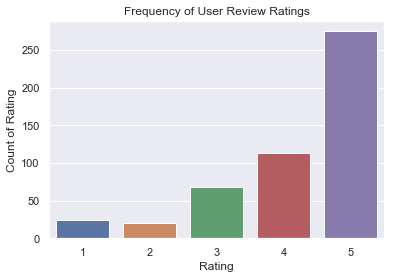

In [370]:
ax=sns.countplot(x='rating',data=reviews); # Ordinal
ax.set_title('Frequency of User Review Ratings')
ax.set_ylabel('Count of Rating')
ax.set_xlabel('Rating')

#### Vote Count

In [371]:
print(reviews.vote_count.value_counts()) # No votes on reviews

0    500
Name: vote_count, dtype: int64


#### App Version

In [372]:
print(reviews.version.value_counts()) # Ordinal 

6.4.2     145
6.2.10     88
6.4.6      55
6.5.2      49
6.1.35     39
6.2.6      37
6.2.17     30
6.5.7      24
6.3.6      16
6.2.20      9
6.4.1       8
Name: version, dtype: int64


#### Data Cleaning

In [373]:
def sentiment_label(df):
    """
    Define labels for sentiment by the user review rating by converting the string to 
    integer. Create new column to define the sentiment.
    
    Params:
        - df
        
    Returns:
        - df['sentiment']
    """
    df['rating']=df['rating'].astype('int')
    df['sentiment']=np.where(df['rating']>=4,1,0)
sentiment_label(reviews)

In [374]:
reviews=reviews[['review','sentiment']] # Subset features of dataframe

In [391]:
"""import emoji
import regex

text=np.array(reviews['review'])
emoji=[]
def strip_emoji(text):
    return [e for e in text if e in emoji]
strip_emoji(text[23])"""

In [413]:
import re
def clean_text(text):
    """
    Remove punctuation and all other characters from the reviews and returned all text
    in lower case format.
    
    Params:
        - Reviews
    Returns:
        - Revised reviews
    
    """
    emoticons=re.findall('(?::|;|=)(?:-)?(?:\)|\(D|P)',text)
    text=(re.sub('[\W]+',' ',text.lower()) + ' '.join(emoticons).replace('-',''))
    return text
reviews['review']=reviews['review'].apply(clean_text)

In [414]:
reviews

,review,sentiment
0,great,1
1,this app lets me be social during my busy life...,1
2,great app love how responsive people are,1
3,i ve had the app for a few months it s pretty ...,1
4,not as good as other apps needs some work to b...,0
5,can t really see anything without buying premi...,1
6,so far so good easy to navigate i m liking it,1
7,it s a good app but gotta fix the catfish issu...,1
8,this app is ideal for meeting a variety of wom...,1
9,perfect app for gay couples,1


In [ ]:
def tokenize():

#### Modeling

In [145]:
from sklearn.feature_extraction.text import CountVectorizer
count=CountVectorizer()

In [146]:
review_doc=np.array(reviews_sub.review)

In [147]:
bag=count.fit_transform(review_doc)

In [148]:
# Tokens of the reviews
count.vocabulary_

{'great': 201,
 'this': 448,
 'app': 34,
 'lets': 255,
 'me': 285,
 'be': 52,
 'social': 423,
 'during': 129,
 'my': 301,
 'busy': 67,
 'life': 257,
 'and': 27,
 'it': 241,
 'just': 244,
 'all': 18,
 'around': 42,
 'love': 274,
 'how': 224,
 'responsive': 392,
 'people': 347,
 'are': 39,
 've': 483,
 'had': 208,
 'the': 441,
 'for': 165,
 'few': 156,
 'months': 296,
 'pretty': 366,
 'good': 198,
 'so': 422,
 'far': 150,
 'not': 313,
 'as': 43,
 'other': 335,
 'apps': 38,
 'needs': 305,
 'some': 424,
 'work': 515,
 'to': 457,
 'on': 327,
 'par': 343,
 'with': 509,
 'big': 59,
 'name': 302,
 'can': 74,
 'really': 385,
 'see': 402,
 'anything': 33,
 'without': 510,
 'buying': 71,
 'premium': 365,
 'but': 68,
 'like': 259,
 'open': 331,
 'is': 238,
 'about': 7,
 'varying': 482,
 'identities': 227,
 'preferences': 364,
 'interested': 236,
 'more': 297,
 'free': 171,
 'trial': 462,
 'easy': 131,
 'navigate': 303,
 'liking': 262,
 'gotta': 199,
 'fix': 162,
 'catfish': 77,
 'issue': 240,
 'to

In [149]:
print(bag.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [125]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf=TfidfTransformer(use_idf=True,
                       norm='l2',
                       smooth_idf=True)

In [126]:
np.set_printoptions(precision=2)

In [127]:
print(tfidf.fit_transform(count.fit_transform(review_doc)).toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
